In [1]:
import pyodbc
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pickle

df = pd.read_csv('./results4.csv')
df.columns = ['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags']

dndf = pd.DataFrame(columns=['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags'])

negatives = ['not', 'no', 'nor', "won't", "wouldn't", "shouldn't", "couldn't", 'against', "aren't", "haven't", "hasn't", "doesn't", "isn't", "don't"]

#tokenize text and lowercase
df['tokText'] = df['text'].apply(lambda x: x.split())
df['tokText'] = df['tokText'].apply(lambda x: [y.lower() for y in x])

for i in range(0, len(df)):
    df['topics'][i] = df['topics'][i].replace("'',", "")
df['topics'] = df['topics'].apply(lambda x: x[1:-1].split(', '))

#if text contains more than 1 negative word, add to dndf
for index, row in df.iterrows():
    if len([x for x in negatives if x in row['tokText']]) > 1:
        dndf = dndf.append(row)

C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3129733175.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topics'][i] = df['topics'][i].replace("'',", "")
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3129733175.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dndf = dndf.append(row)
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3129733175.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dndf = dndf.append(row)
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3129733175.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [2]:
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.similarities import SoftCosineSimilarity

#from a selected text, find the most similar users and predict sentiment towards the text based on the topic
selectedIndex = 19
selectedIndex = df[df['text'] == dndf.iloc[selectedIndex]['text']].index[0]

userDF = pd.DataFrame(columns=['id', 'topics',])
userDF.id = df.id.unique()
#add all unique topics to userDF by id unless it is empty
for i in range(0, len(userDF)):
    userDF['topics'][i] = df[df['id'] == userDF['id'][i]]['topics'].sum()
    userDF['topics'][i] = [x for x in userDF['topics'][i] if x != "\'\'"]
    
userDF['topics'].to_csv('./test.csv', index=False)

#change sentiment 4 to 1
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else x)

#for each topic add sentiment based on mean of sentiment of the user's tweets with that topic
for i in range(0, len(userDF)):
    for j in range(0, len(userDF['topics'][i])):
        userDF['topics'][i][j] = userDF['topics'][i][j] + str((df[(df['id'] == userDF['id'][i]) & (df['topics'].apply(lambda x: userDF['topics'][i][j] in x))]['sentiment'].mean()).round(2))

userDF['topicsRaw'] = pd.read_csv('./test.csv')['topics']

#convert array of topicsRaw to string
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: str(x))

#clean topicsRaw and convert to array
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x.replace("\"", ""))
userDF['topicsRaw'] = userDF['topicsRaw'].apply(lambda x: x[1:-1].split(', '))

#using soft cosine similarity return 10 most similar users to a given user
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
documents = userDF['topics']
dictionary = Dictionary(documents)
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
index = WordEmbeddingSimilarityIndex(fasttext_model300)
sims = SparseTermSimilarityMatrix(index, dictionary)
model = SoftCosineSimilarity(bow_corpus, sims, num_best=10)

def get_recommendations(id):
    idx = userDF.index[userDF['id'] == id][0]
    query = userDF['topics'][idx]
    query = dictionary.doc2bow(query)
    return model[query]

#get closest users to the given user to predict sentiment towards a topic
results = get_recommendations(df['id'][selectedIndex])

#only use users with a distance of less than 0.3
results = [x for x in results if x[1] < 0.3 ]

#assign user{number} to each user
userDF['user'] = ["user" + str(i) for i in range(0, len(userDF))]
userDF['userNum'] = [str(i) for i in range(0, len(userDF))]

print("Closest users to", userDF.loc[userDF['id'] == df['id'][selectedIndex], 'user'].iloc[0], "are:", [userDF['user'][x[0]] for x in results], "with distances of:", [x[1] for x in results])

#predict sentiment towards the chosen text based on the closest users' sentiment towards the topic
topics = df['topics'][selectedIndex]

#find texts from close users with at least 1 topic in common with the chosen text and add to df
closeDF = pd.DataFrame(columns=['id', 'text', 'modText', 'sentiment', 'topics', 'hashtags'])
for i in range(0, len(results)):
    closeDF = closeDF.append(df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: any(item in x for item in topics)))])


100%|██████████| 1483/1483 [00:00<00:00, 296480.12it/s]

Closest users to user5 are: ['user8', 'user4', 'user7', 'user3', 'user6', 'user10', 'user0', 'user13'] with distances of: [0.21700067818164825, 0.20789580047130585, 0.17816729843616486, 0.17083290219306946, 0.1582115888595581, 0.15551349520683289, 0.14087645709514618, 0.13326653838157654]



C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gensim\similarities\termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\2678368325.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closeDF = closeDF.append(df[(df['id'] == userDF['id'][results[i][0]]) & (df['topics'].apply(lambda x: any(item in x for item in topics)))])
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\2678368325.py:71: FutureWarni

In [3]:
#perform knn on the close users' sentiment towards the topic
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

closeDF = closeDF.append(pd.Series(), ignore_index=True)
chosenTopics = df['topics'][selectedIndex]
closeDF['topics'].iloc[-1] = chosenTopics

closeDF['topics'] = closeDF['topics'].astype(str)
closeDF['topics'] = closeDF['topics'].astype(pd.StringDtype())
for i in range(0, len(closeDF)):
    closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("'", "")
    closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace(",", "")
    closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("[", "")
    closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("]", "")
    closeDF['topics'].iloc[i] = closeDF['topics'].iloc[i].replace("\"", "")

#encode topics as bag of words
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=100, stop_words='english')
X = vectorizer.fit_transform(closeDF['topics'].astype(str))
X = pd.DataFrame(X.todense())

#train knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X[:-1].astype(int), closeDF['sentiment'][:-1].astype(int))

#predict sentiment towards the chosen text
closeDF['sentiment'].iloc[-1] = knn.predict(X[-1:])

print("Predicted sentiment towards", df['text'][selectedIndex], "is", closeDF['sentiment'].iloc[-1])
print("Original sentiment towards", df['text'][selectedIndex], "is", df['sentiment'][selectedIndex])

Predicted sentiment towards I voted against the $858 billion Pentagon budget because it’s time to invest in health care, jobs, housing and education – not more weapons of destruction. https://t.co/2dTYskCLRe is [0]
Original sentiment towards I voted against the $858 billion Pentagon budget because it’s time to invest in health care, jobs, housing and education – not more weapons of destruction. https://t.co/2dTYskCLRe is 0


C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3296170721.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  closeDF = closeDF.append(pd.Series(), ignore_index=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3296170721.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  closeDF = closeDF.append(pd.Series(), ignore_index=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_5804\3296170721.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closeDF['sentiment'].iloc[-1] = knn.predict(X[-1:])


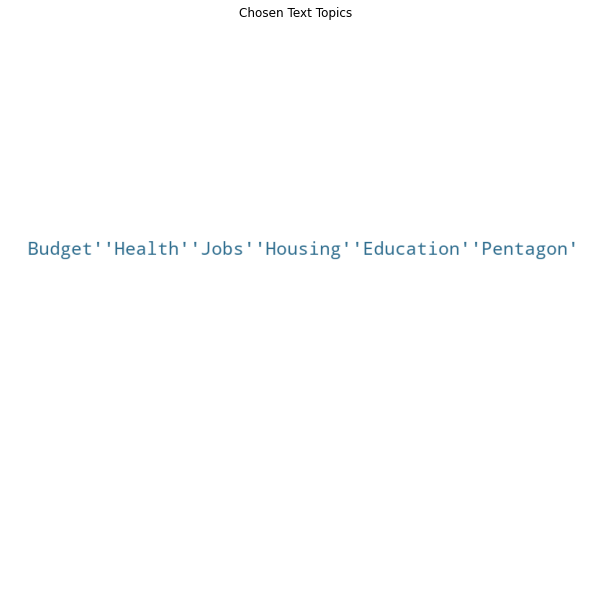

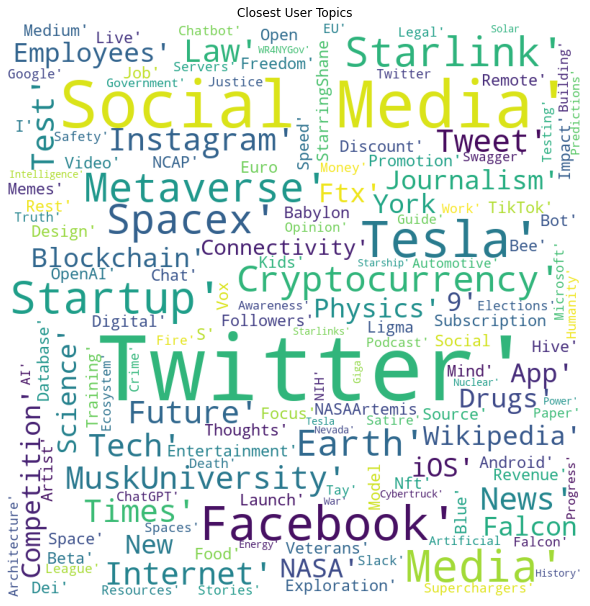

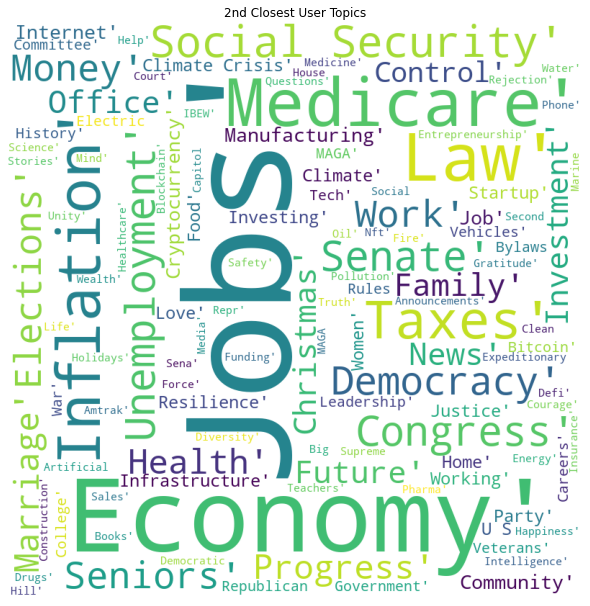

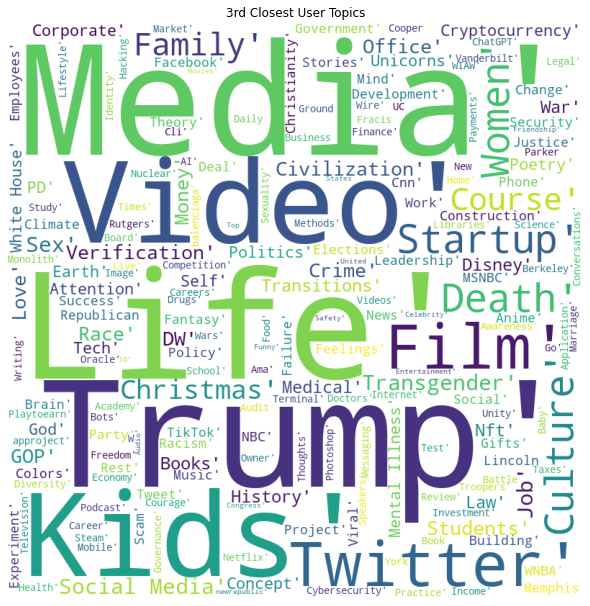

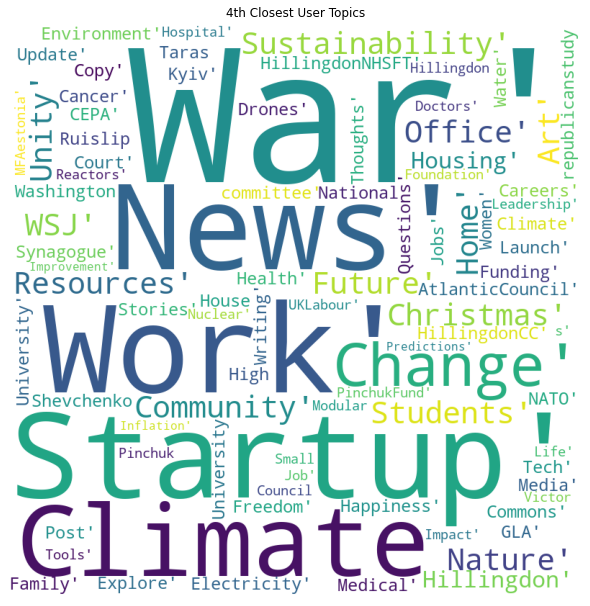

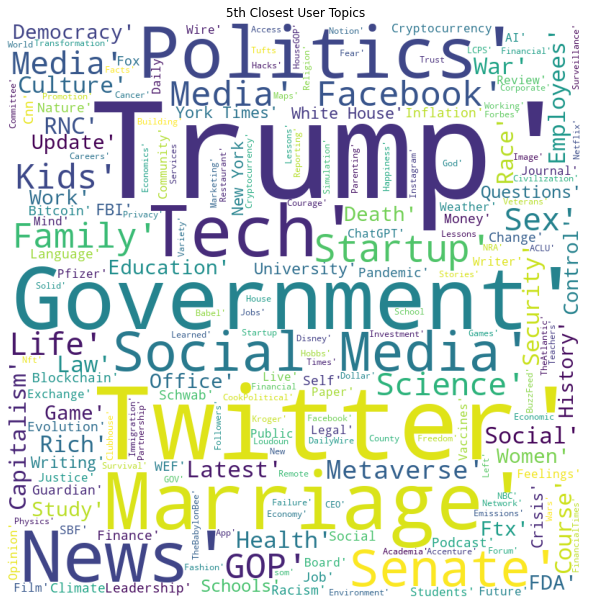

Predicted sentiment towards I voted against the $858 billion Pentagon budget because it’s time to invest in health care, jobs, housing and education – not more weapons of destruction. https://t.co/2dTYskCLRe is [0]
Original sentiment towards I voted against the $858 billion Pentagon budget because it’s time to invest in health care, jobs, housing and education – not more weapons of destruction. https://t.co/2dTYskCLRe is 0


In [9]:
#visualize the chosen texts topics, the closest users' topics, the predicted sentiment towards the chosen text and the original sentiment towards the chosen text

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()
    
wordcloud(''.join(df['topics'][selectedIndex]), "Chosen Text Topics")
wordcloud(" ".join(userDF['topicsRaw'][results[0][0]]), "Closest User Topics")
wordcloud(" ".join(userDF['topicsRaw'][results[1][0]]), "2nd Closest User Topics")
wordcloud(" ".join(userDF['topicsRaw'][results[2][0]]), "3rd Closest User Topics")
wordcloud(" ".join(userDF['topicsRaw'][results[3][0]]), "4th Closest User Topics")
wordcloud(" ".join(userDF['topicsRaw'][results[4][0]]), "5th Closest User Topics")

print("Predicted sentiment towards", df['text'][selectedIndex], "is", closeDF['sentiment'].iloc[-1])
print("Original sentiment towards", df['text'][selectedIndex], "is", df['sentiment'][selectedIndex])